## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sn

/home/anna/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
import pandas as pd

## Загружаем исходные данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
del train
del test

In [6]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

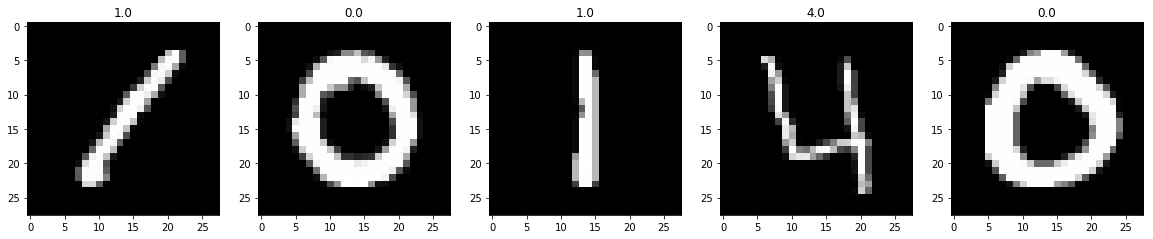

In [7]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [8]:
SZ=28

for i, img in enumerate(train_img):
    m=cv2.moments(img)
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img2 = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    train_img[i]=img2
    m2=cv2.moments(img2)
    skew2 = m2['mu11']/m2['mu02']

In [9]:
for i, img in enumerate(train_img):
    blur = cv2.GaussianBlur(img,(3,3),0)
    train_img[i]=blur

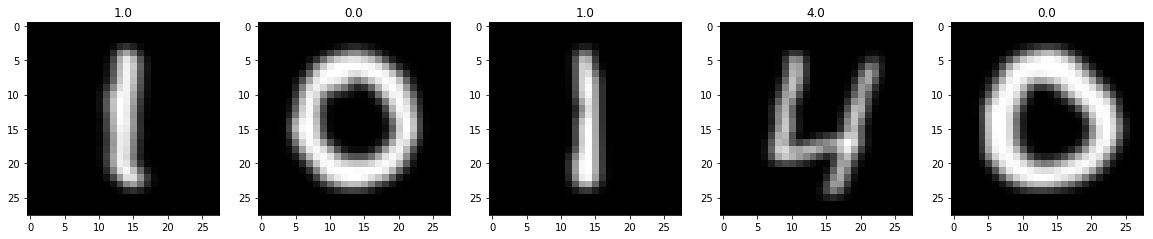

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5]):
    subplot = fig.add_subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i]);

In [11]:
SZ=28

for i, img in enumerate(test_img):
    m=cv2.moments(img)
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img2 = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    test_img[i]=img2
    m2=cv2.moments(img2)
    skew2 = m2['mu11']/m2['mu02']

In [12]:
for i, img in enumerate(test_img):
    blur = cv2.GaussianBlur(img,(3,3),0)
    test_img[i]=blur

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [16]:
def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)

In [14]:
train_img_flatten=train_img.reshape(42000,-1)

In [15]:
test_img_flatten=test_img.reshape(28000,-1)

In [19]:
clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
score_array = np.zeros(len(n_components_array))


for i, n_components in enumerate(n_components_array):
    pca = PCA(n_components=n_components)
    pca.fit(train_img_flatten)
    transform = pca.transform(train_img_flatten)
    score_array[i] = evaluate_classifier(clf, transform, train_label.tolist(), 0.8)
    

/home/anna/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


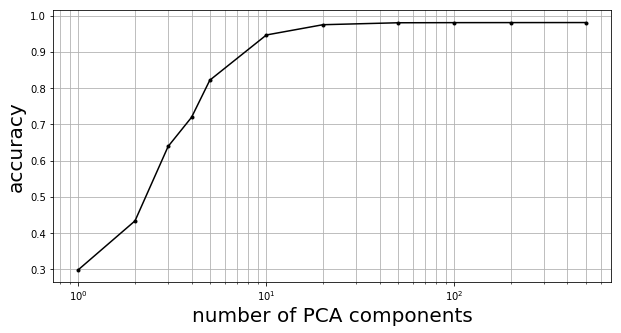

In [20]:
plt.figure(figsize=(10,5))
plt.plot(n_components_array,score_array,'k.-')
plt.xscale('log')
plt.xlabel("number of PCA components", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(which="both")

In [16]:
pca = PCA(n_components=50)
pca.fit(train_img_flatten)
transform_train = pca.transform(train_img_flatten)
transform_test = pca.transform(test_img_flatten)

clf = KNeighborsClassifier()
clf.fit(transform_train,train_label)
train_predictions=clf.predict(transform_train)
results=clf.predict(transform_test)


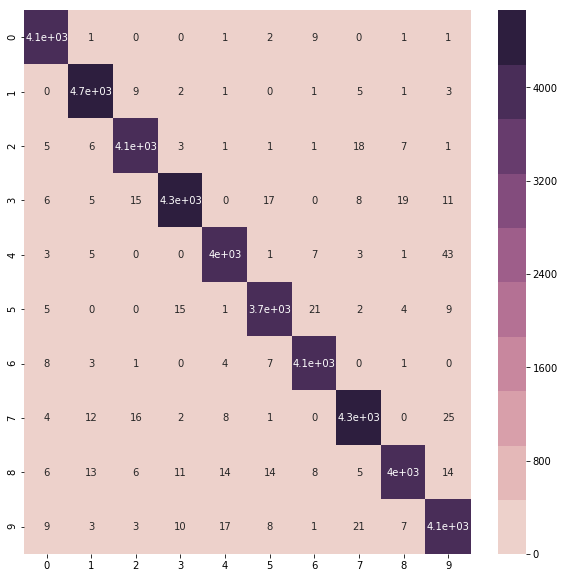

In [17]:
conf_array = confusion_matrix(train_label, train_predictions)
conf_df = pd.DataFrame(conf_array, index = range(10), columns = range(10))
plt.figure(figsize = (10, 10))
sn.heatmap(conf_df, annot=True, cmap=sn.cubehelix_palette(10))

In [18]:
np.savetxt('results_clf.csv', 
           np.c_[range(1,len(transform_test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

# Kaggle score 0.98228

## Обучаем нейронную сеть

In [19]:
import keras

Using Theano backend.


In [20]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=transform_train.shape[1],
                             activation='relu',
                            kernel_initializer ='random_normal',
                            kernel_regularizer=keras.regularizers.l2(0.01)))

model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 3,018
Trainable params: 3,018
Non-trainable params: 0
_________________________________________________________________


In [22]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(train_label)

In [23]:
model.fit(transform_train, y_train_labels, 
          batch_size=32, validation_split=0.2,
          epochs=100)

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
33600/33600 [==============================] - 0s - loss: 4.2037 - acc: 0.6885 - val_loss: 2.3989 - val_acc: 0.8201
Epoch 2/100
33600/33600 [==============================] - 0s - loss: 2.2950 - acc: 0.8323 - val_loss: 2.1316 - val_acc: 0.8463
Epoch 3/100
33600/33600 [==============================] - 0s - loss: 2.0935 - acc: 0.8514 - val_loss: 2.0215 - val_acc: 0.8552
Epoch 4/100
33600/33600 [==============================] - 0s - loss: 1.9914 - acc: 0.8596 - val_loss: 1.9750 - val_acc: 0.8574
Epoch 5/100
33600/33600 [==============================] - 0s - loss: 1.9292 - acc: 0.8646 - val_loss: 1.9288 - val_acc: 0.8638
Epoch 6/100
33600/33600 [==============================] - 0s - loss: 1.8800 - acc: 0.8688 - val_loss: 1.9182 - val_acc: 0.8635
Epoch 7/100
33600/33600 [==============================] - 0s - loss: 1.8484 - acc: 0.8718 - val_loss: 1.9041 - val_acc: 0.8657
Epoch 8/100
33600/33600 [==============================

33600/33600 [==============================] - 0s - loss: 0.0608 - acc: 0.9875 - val_loss: 0.1779 - val_acc: 0.9674
Epoch 65/100
33600/33600 [==============================] - 0s - loss: 0.0610 - acc: 0.9874 - val_loss: 0.1761 - val_acc: 0.9675
Epoch 66/100
33600/33600 [==============================] - 0s - loss: 0.0604 - acc: 0.9872 - val_loss: 0.1699 - val_acc: 0.9675
Epoch 67/100
33600/33600 [==============================] - 0s - loss: 0.0598 - acc: 0.9875 - val_loss: 0.1723 - val_acc: 0.9682
Epoch 68/100
33600/33600 [==============================] - 0s - loss: 0.0597 - acc: 0.9875 - val_loss: 0.1813 - val_acc: 0.9685
Epoch 69/100
33600/33600 [==============================] - 0s - loss: 0.0586 - acc: 0.9879 - val_loss: 0.1720 - val_acc: 0.9685
Epoch 70/100
33600/33600 [==============================] - 0s - loss: 0.0579 - acc: 0.9876 - val_loss: 0.1772 - val_acc: 0.9695
Epoch 71/100
33600/33600 [==============================] - 0s - loss: 0.0567 - acc: 0.9882 - val_loss: 0.1689

In [26]:
transform_train.shape

(42000, 50)

In [27]:
transform_test.shape

(28000, 50)

In [28]:
pred_val = model.predict_classes(transform_test)

27520/28000 [============================>.] - ETA: 0s

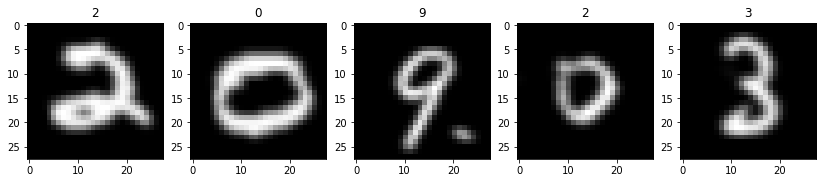

In [29]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_val[i - 1]);

In [32]:
with open('results_nn.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_val, 1):
        dst.write('%s,%s\n' % (i, p))
        
        
# Kaggle score 0.96871

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [23]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [24]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [31]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [27]:
train_g.shape 

(42000, 28, 28)

In [ ]:
for i in [0,14]:
    for j in [0,14]:
        train_g_quat(i,j) = cv2.cartToPolar(
            train_sobel_x(:, i:i+13, j:j+13),
            train_sobel_x(:, i:i+13, j:j+13))
        
        test_g_quat(i,j) = cv2.cartToPolar(
            test_sobel_x(:, i:i+13, j:j+13),
            test_sobel_x(:, i:i+13, j:j+13))
            

In [29]:
train_sobel_x.shape

(42000, 28, 28)

In [72]:
train_g_flatten =train_g.reshape(42000,-1) 
test_g_flatten =test_g.reshape(28000,-1) 

In [73]:
for i, n_components in enumerate(n_components_array):
    pca = PCA(n_components=n_components)
    pca.fit(train_g_flatten)
    transform = pca.transform(train_g_flatten)
    score_array[i] = evaluate_classifier(clf, transform, train_label, 0.8)

C:\Program Files\Python36\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


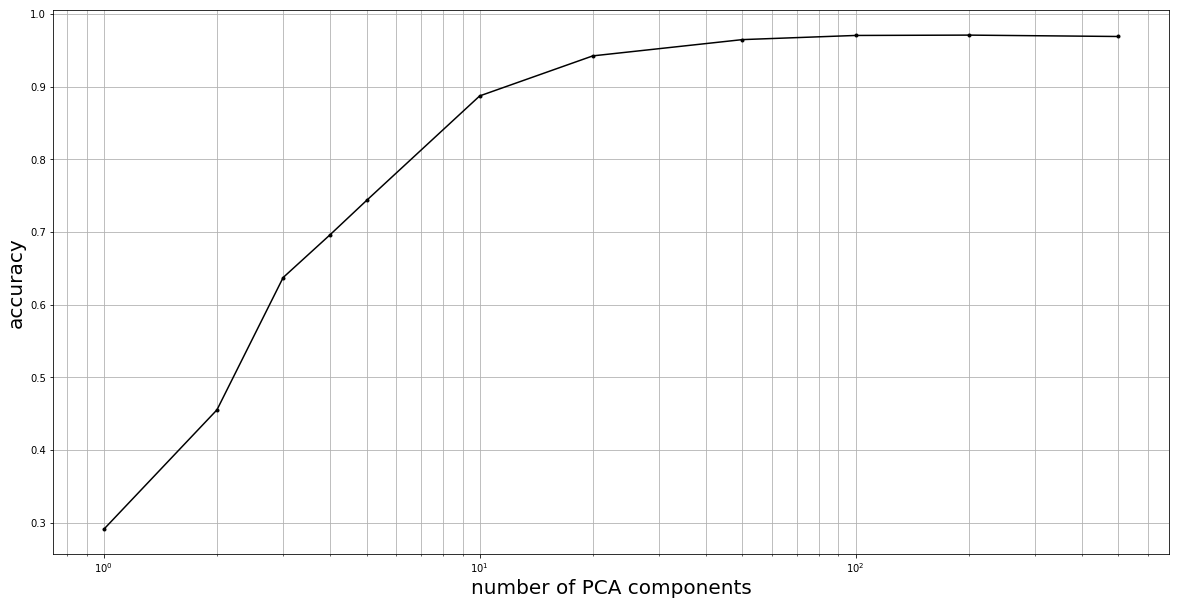

In [75]:
plt.figure(figsize=(20,10))
plt.plot(n_components_array,score_array,'k.-')
plt.xscale('log')
plt.xlabel("number of PCA components", size=20)
plt.ylabel("accuracy", size=20)
plt.grid(which="both")

In [76]:
pca = PCA(n_components=100)
pca.fit(train_g_flatten)
transform_train = pca.transform(train_g_flatten)
transform_test = pca.transform(test_g_flatten)

clf = KNeighborsClassifier()
clf.fit(transform_train,train_label)
train_predictions=clf.predict(transform_train)
results=clf.predict(transform_test)

In [77]:
np.savetxt('results.csv', 
           np.c_[range(1,len(transform_test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

# Kaggle score 0.96914